In [1]:
%matplotlib inline

import random
import h5py
import numpy as np
import sys
import os
from tqdm import tqdm_notebook as tqdm
import tflearn
import tensorflow as tf
import math
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output



/home/luc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def calc_distance(predictions, targets, inputs):
    return tf.nn.l2_loss(tf.subtract(predictions, targets), name='l2')

net = tflearn.input_data(shape=[None, 8])
net = tflearn.batch_normalization(net)
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 500, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 5000, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 5000, activation='relu', regularizer='L2')
net = tflearn.fully_connected(net, 5000, activation='tanh', regularizer='L2')
net = tflearn.fully_connected(net, 1, activation='linear', regularizer='L2')

net = tflearn.regression(net, metric=None, loss='mean_square')
model = tflearn.DNN(net, checkpoint_path='./model_checkpoints')

model.load('./models/dnn.tflearn')

INFO:tensorflow:Restoring parameters from /home/luc/Projects/conny/models/dnn.tflearn


In [4]:
h5f = h5py.File('data/data.h5', 'r')
X = h5f['X_test'][:][:, [0,1,2,3,4,6]]
bound_low  = np.min(X, axis=0)
bound_high = np.max(X, axis=0)
bound_low[5] = 0.01 # Limit from grid

In [123]:
star = json.load(open('./stars/star2-relative.json'))
settings = {
    "initial_iteration_size": 5000,
    "iteration_size": 1000,
    "iteration_count": 10,
    "active_points": 200
}


In [118]:
# Set up random sampling and particle filter functions
def random_sample():
    return [[np.random.uniform(bound_low[i], bound_high[i]) for i in range(len(bound_low))] for x in range(settings["initial_iteration_size"])]

def gauss_sample(seeds, i, spread):
    def bound(low, high, value):
        return max(low, min(high, value))
    def gauss_sample_single(seed):
        return [
            bound(bound_low[i], bound_high[i], np.random.normal(seed[i], seed[i]*spread))
                for i in range(len(seed) - 1)
        ]
    return [gauss_sample_single(random.choice(seeds)) for x in range(settings['iteration_size'])]

In [119]:
def calculate_point(point):
    inputs = []
    for l in range(3):
        for n_pg in range(-50, 6):
            inputs.append(point + [l] + [n_pg])
    outputs = model.predict(inputs)
    return outputs

def get_point_index(l, n_pg):
    return 56*l + n_pg + 50
def get_error(y1, y2):
    return (y1-y2)**2

# Set up function to determine error of a point
def point_error(points, verbose = False):
    global model
    errors = []
    
    if verbose == True:
        best_list = []
    
    for point in tqdm(points):
        # Append l and n_pg to all points
        y_pred = calculate_point(point)
        y_true = star['data']
        
        if star['settings']['match_mode'] == 'relative':
            min_err = math.inf
            # Only with fixed l and relative but fixed n_pg
            # Take min and max n_pg values to scan around
            min_n_pg = -50
            
            max_n_pg = 5
            if 'max_n_pg' in star['settings']:
                max_n_pg = star['settings']['max_n_pg']
            max_n_pg = max_n_pg - y_true[-1]['n_pg']
            
            # Calculate least error
            for n_pg_idx in range(min_n_pg, max_n_pg):
                current_error = 0
                for y in y_true:
                    point_index = get_point_index(y['l'], n_pg_idx+y['n_pg'])
                    current_error += get_error(y_pred[point_index], y['freq'])
                if current_error < min_err:
                    min_err = current_error
                    best_n_pg_idx = n_pg_idx
                    
            if verbose == True:
                best_list.append(best_n_pg_idx)
            point_error = min_err
        else:
            # Exact match: calculate error for all star samples independently
            point_error = 0
            prev_n_pg = False
            for idx, y in enumerate(y_true):

                # Exact match
                if 'l' in y and 'n_pg' in y:
                    if type(y['l']).__name__ == 'int':
                        point_index = get_point_index(y['l'], y['n_pg'])
                        point_error += get_error(y_pred[point_index], y['freq'])
                        prev_l = y['l']
                        prev_n_pg = y['n_pg']
                        if verbose == True:
                            best_list.append([prev_l, prev_n_pg])
                    else:
                        min_err = math.inf
                        for l in y['l']:
                            point_index = get_point_index(l, y['n_pg'])
                            current_error = get_error(y_pred[point_index], y['freq'])
                            if current_error < min_err:
                                min_err = current_error
                                prev_l = l
                                prev_n_pg = y['n_pg']
                        point_error += min_err
                        if verbose == True:
                            best_list.append([prev_l, prev_n_pg])
                elif 'l' in y and 'n_pg_max' in y:
                    # Get the max n_pg
                    n_pg_max = y['n_pg_max']
                    if (n_pg_max == 'prev'):
                        n_pg_max = prev_n_pg
                    # Get the min n_pg (-50 + amount of following frequencies)
                    n_pg_min = -50 + len(y_true)-1 - idx
                    if 'n_pn_min' in y:
                        n_pg_min = y['n_pg_min']


                    if type(y['l']).__name__ == 'int':
                        min_err = math.inf
                        for n_pg in range(n_pg_min, n_pg_max):
                            point_index = get_point_index(y['l'], n_pg)
                            current_error = get_error(y_pred[point_index], y['freq'])
                            if current_error < min_err:
                                min_err = current_error
                                prev_l = y['l']
                                prev_n_pg = n_pg
                        point_error += min_err
                        if verbose == True:
                            best_list.append([prev_l, prev_n_pg])
                    else:
                        min_err = math.inf
                        for l in y['l']:
                            for n_pg in range(n_pg_min, n_pg_max):
                                point_index = get_point_index(l, n_pg)
                                current_error = get_error(y_pred[point_index], y['freq'])
                                if current_error < min_err:
                                    min_err = current_error
                                    prev_l = l
                                    prev_n_pg = n_pg
                        point_error += min_err
                        if verbose == True:
                            best_list.append([prev_l, prev_n_pg])
                else:
                    print("Could not parse", y)


            
            
        point_error /= len(star['data'])
        errors.append(point_error)
    if verbose == True:
        return np.array(errors), best_list
    return np.array(errors)

x=([random_sample()[0]])
print(point_error(x))



[[0.01690665]]


In [120]:
def create_plot(Data, save_to_disk = False):
    fig = plt.figure(figsize=(30,20))
    plt.suptitle(star['settings']['title'], fontsize=32, y=0.92)
    plt.rc('text', usetex=True)
    def add_plot(fig, fig_key, x, y, x_label, c_label):
        ax = fig.add_subplot(3,3,fig_key)
        ax.scatter(Data[:,x], Data[:,y])
        ax.set_xlabel(x_label, size=25)
        ax.set_yscale('log')
        ax.set_ylabel(c_label, size=25)
        axes = fig.gca()
        ax.xaxis.set_tick_params(labelsize=25)
        ax.yaxis.set_tick_params(labelsize=25)
        axes.set_xlim([np.min(Data[:,x]), np.max(Data[:,x])])
        axes.set_ylim([np.min(Data[:,y])/1.2, np.max(Data[:,y])*1.2])

    add_plot(fig, 1, 0, 6, r'$M_\odot$', r'$\chi^2$')
    add_plot(fig, 2, 3, 6, r'$f_{\rm ov}$', r'$\chi^2$')
    add_plot(fig, 3, 1, 6, 'Z', r'$\chi^2$')
    add_plot(fig, 4, 5, 6, r'$X_c$', r'$\chi^2$')
    add_plot(fig, 5, 4, 6, r'$D_{\rm mix} (cm^2\,s^{-1}$', r'$\chi^2$')
    add_plot(fig, 6, 2, 6, r'X', r'$\chi^2$')

    #ax = fig.add_subplot(3,3,6)
    #ax.scatter(data[:,5], data[:,6])
    #ax.set_xlabel('center_h1')
    #ax.set_yscale('log')
    #ax.set_ylabel('chi2')
    #axes = fig.gca()
    #axes.set_ylim([0.001, 0.1])

    if save_to_disk == True:
        fig.savefig('./stars/results/'+star['settings']['filename']+'.png', pad_inches=0, bbox_inches='tight')
        print("Saved to disk")
    else:
        clear_output()
        fig.show()
        plt.pause(0.0001)

In [121]:
iteration_num=1
result_list = np.empty((0, 7))
for i in tqdm(range(3*settings['iteration_count'])):
    if (i == 0):
        sample = random_sample()
    elif i < settings['iteration_count']:
        sample = gauss_sample(result_list[:settings['active_points']], i, 0.4)
    elif i < settings['iteration_count']*2:
        sample = gauss_sample(result_list[:settings['active_points']], i, 0.1)
    else:
        sample = gauss_sample(result_list[:settings['active_points']], i, 0.01)
    errors = point_error(sample)
    errors = np.array(errors).reshape(len(errors), 1)
    result = np.hstack((np.array(sample), errors))
    result_list = np.vstack((result_list, result))
    result_list = np.array(sorted(result_list, key=lambda row: row[-1]))
    
    #create_plot(result_list)

print("Done")

Done


Saved to disk


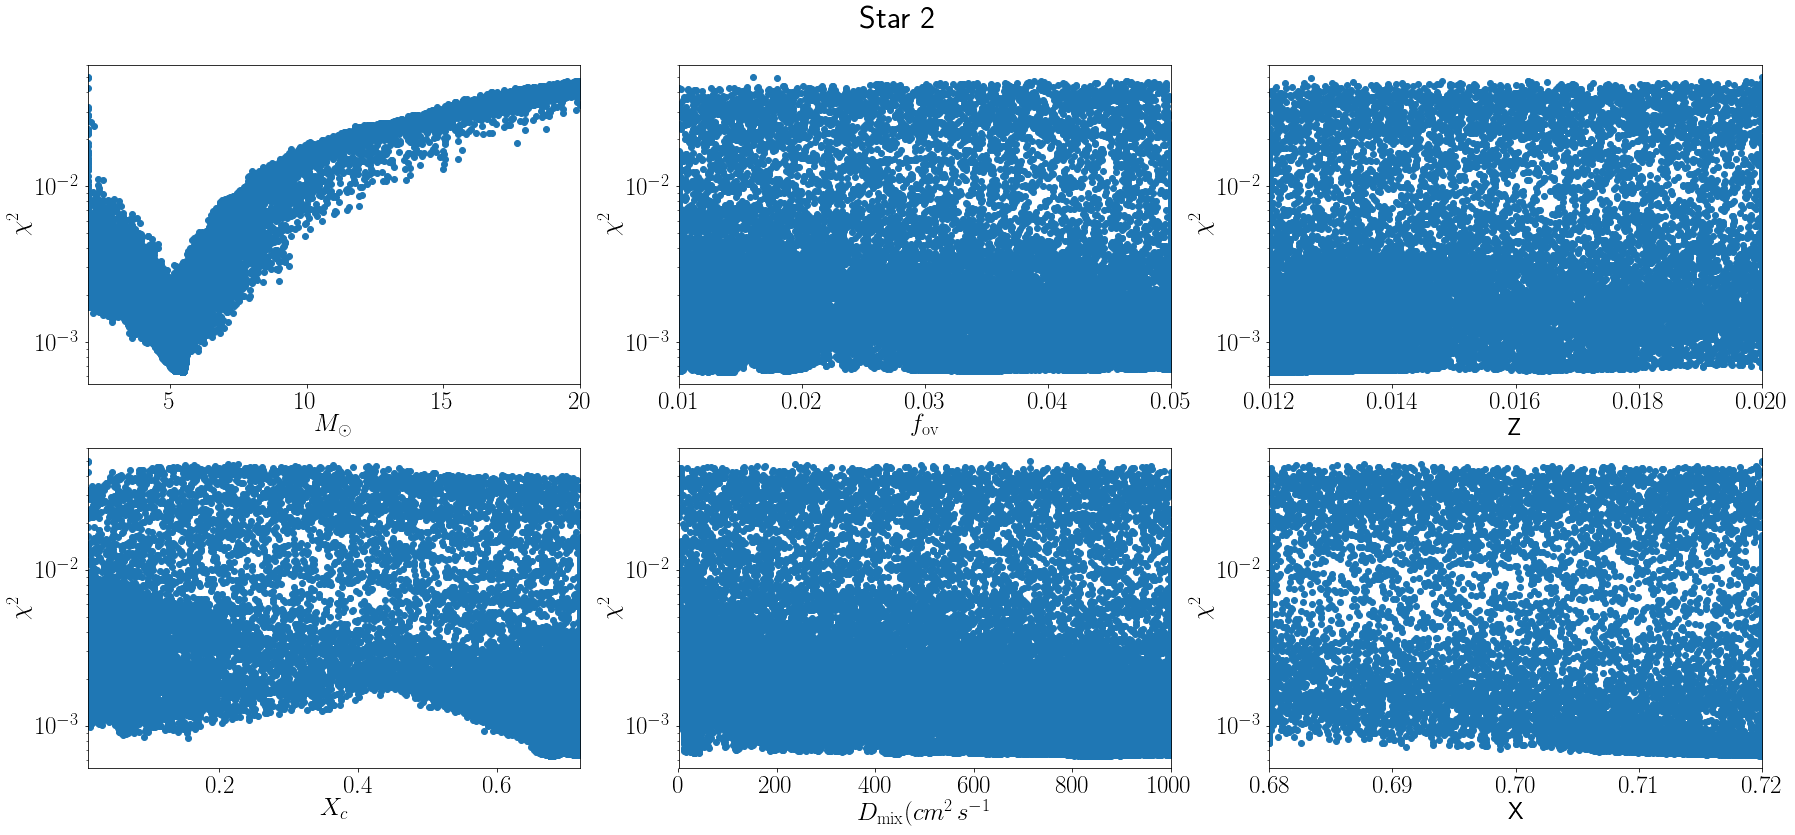

In [124]:
create_plot(result_list, True)
inputs = [result_list.tolist()[0][:-1]]
errors = point_error(inputs, True)

text_file = open("./stars/results/"+star['settings']['filename']+".txt", "w")
text_file.write("Best point:\n")

text_file.write("M: %s\n" % inputs[0][0])
text_file.write("Z: %s\n" % inputs[0][1])
text_file.write("Xi: %s\n" % inputs[0][2])
text_file.write("ov: %s\n" % inputs[0][3])
text_file.write("D: %s\n" % inputs[0][4])
text_file.write("center_h1: %s\n" % inputs[0][5])


text_file.write("Best point has error: %s" % errors[0][0][0])



if star['settings']['match_mode'] == 'relative':
    text_file.write("\nn_pg absolute index: %s" % errors[1][0])
else:
    text_file.write("\nfreq, l, n_pg value table:\n")
    for i in range(len(star['data'])):
        text_file.write("%s %s %s\n" % (star['data'][i]['freq'], *(errors[1][i])))

text_file.close()
np.savetxt('./stars/results/'+star['settings']['filename']+'.csv', result_list)